In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc
import tensorflow as tf
import pprint
import cv2 as cv
from functools import reduce
import tensorflow.compat.v1 as tfc
import imageio as io
from PIL import Image
import IPython.display as display
import PIL.Image

In [3]:
MODEL_FILE = 'VGG-19/imagenet-vgg-verydeep-19.mat'
NOISE_LEVEL = 0.3
CHANNELS = 3
HEIGHT = 300
WIDTH = 400
SHAPE = (1,HEIGHT,WIDTH,CHANNELS)
MEAN_PIXELS_VGG = np.array([103.939,116.779,123.68]).reshape((1,1,3))
LAPLACIAN_FILTER = np.array([ [0,-1,0], [-1,4,-1], [0,-1,0] ], dtype=np.float32 )

In [4]:
def read_image(file):
    img = plt.imread(file)
    if len(img.shape) == 2:
        # grayscale
        img = np.dstack((img,img,img))
    elif img.shape[2] == 4:
        # PNG with alpha channel
        img = img[:,:,:3]
    img = cv.resize(img, (WIDTH, HEIGHT))
    return img

In [23]:
CONTENT_WEIGHT = 5
LAP_LAYERS_ = ['1']
LAP_WEIGHT = 5e1
STYLE_WEIGHT = 5e2
LEARNING_RATE = 1
BETA1 = 0.9
BETA2 = 0.999
EPSILON = 1e-08
ITERATIONS = 1000
CONTENT_IMAGE_PATH = r'C:\Users\abdul\Desktop\CS 512 - Computer vision\Project\data\goat.png'
STYLE_IMAGE_PATH = r'C:\Users\abdul\Desktop\CS 512 - Computer vision\Project\data\muse.jpg'
CONTENT_IMAGE = read_image(CONTENT_IMAGE_PATH)
STYLE_IMAGE = read_image(STYLE_IMAGE_PATH)

In [24]:
LAYERS = ['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

            'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

            'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
            'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
    
            'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
            'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

            'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
            'relu5_3', 'conv5_4', 'relu5_4']

In [25]:
LAP_LAYERS = ['pool_lap1', 'lap1', 'pool_lap2', 'lap2', 'pool_lap3', 'lap3']
CONTENT_LAYER = ['conv4_2']
STYLE_LAYERS = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

(300, 400, 3)

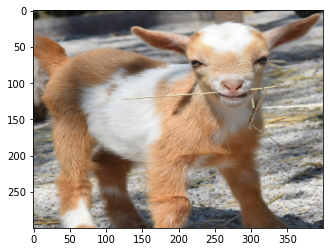

In [26]:
c = read_image(CONTENT_IMAGE_PATH)
plt.imshow(c)
c.shape

(300, 400, 3)

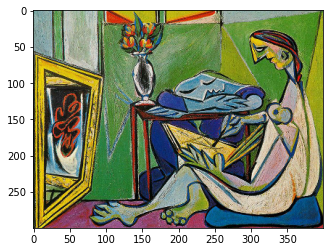

In [27]:
s = read_image(STYLE_IMAGE_PATH)
plt.imshow(s)
s.shape

In [28]:
cont_image=read_image(CONTENT_IMAGE_PATH)
cont_image = cv.resize(cont_image, (WIDTH, HEIGHT))

In [29]:
def load_vgg_model(file):
    vgg = scipy.io.loadmat(file)
    weights = vgg['layers'][0]
    return weights

In [30]:
vgg_weights = load_vgg_model(MODEL_FILE)

In [31]:
def forward(weights, input_image):
    net = {}
    curr_layer = input_image
    for i, name in enumerate(LAYERS):
        sub = name[:4]
        if sub == 'conv':
            kernels_and_biases = weights[i][0][0][2]
            kernels = kernels_and_biases[0][0]
            bias = kernels_and_biases[0][1]
            kernels = tfc.constant(kernels)
            bias = tfc.constant(np.reshape(bias, (bias.size)))
            curr_layer = _conv_layer(curr_layer, kernels, bias)
        elif sub == 'relu':
            curr_layer = tfc.nn.relu(curr_layer)
        elif sub == 'pool':
            curr_layer = _pool_layer(curr_layer)
            
        net[name] = curr_layer

    for i in range(1,4):
        # apply pooling before laplacian layers
        net['pool_lap{0}'.format(i)] = _pool_layer( input_image, 2**i )
        net['lap{0}'.format(i)] = _lap_layer(net['pool_lap{0}'.format(i)])

    return net

In [32]:
def _conv_layer(input_to_layer, weights, bias):
    return (tfc.nn.conv2d(input_to_layer, filters=weights, strides=[1, 1, 1, 1], padding='SAME') + bias)

In [33]:
def _pool_layer(input_to_layer, poolsize=2):
    return (tfc.nn.avg_pool(input_to_layer, ksize=[1, poolsize, poolsize, 1], 
                           strides=[1, poolsize, poolsize, 1], padding='SAME'))

In [34]:
def _lap_layer(input_to_layer):
    laplacian = LAPLACIAN_FILTER
    lap_tensor = np.zeros((3, 3, 1, 1), dtype=np.float32)
    lap_tensor[:,:,0,0] = laplacian
    color_outs = []
    for i in range(3):
        color = input_to_layer[:,:,:,i]
        color4d = tfc.expand_dims(color, -1)
        color_out = _conv_layer(color4d, lap_tensor, [0.0])
        color_outs.append(color_out)
    out = tfc.concat(color_outs, axis=-1)
    out = tfc.abs(out)
    summation = tfc.reduce_sum(out, reduction_indices=[3], keep_dims=False)

    return summation

In [35]:
def preprocess_image(img):
    img = img - MEAN_PIXELS_VGG
    return img

In [36]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [37]:
def revert_image(img):
    return (img + MEAN_PIXELS_VGG)

In [38]:
def save_image(path, image):
    
    # Un-normalize the image so that it looks good
    image = revert_image(image)
    
    # clip and save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
#     io.imwrite(path, image)
    Image.fromarray(image).save(path, quality=95)

In [39]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d for d in tensor.get_shape()), 1)

In [42]:
def styled_output(iterations, noise_level, content, style, content_weight,
                 style_weight, lap_weight, lap_layers, learning_rate, beta1,
                 beta2, epsilon):
    '''
    This function returns styled output images from the CNN
    at each iteration
    '''
    
    # obtain image shapes
    content_shape = (1,) + content.shape
    style_shape = (1,) + style.shape
    
    content_features = {}
    style_features = {}
    
    # weighting requires total weights must sum to 1
    const_style_weight = 1 / len(STYLE_LAYERS)
    style_layers_weights = {}
    for style_layer in STYLE_LAYERS:
        style_layers_weights[style_layer] = const_style_weight
        
    for layer in lap_layers:
        CONTENT_LAYER.append('lap'+layer)
        
    # run forward prop on content image
    graph = tfc.Graph()
    with graph.as_default(), tfc.Session() as session:
        image = tfc.placeholder('float', shape=SHAPE)
        net = forward(vgg_weights, image)
        content_trans = preprocess_image(content)
        content_trans = np.array([content_trans])
        for layer in CONTENT_LAYER:
            content_features[layer] = net[layer].eval(feed_dict={image: content_trans})
            
    # run forward prop on style image
    graph = tfc.Graph()
    with graph.as_default(), tfc.Session() as session:
        image = tfc.placeholder('float', shape=SHAPE)
        net = forward(vgg_weights, image)
        style_trans = preprocess_image(style)
        style_trans = np.array([style_trans])
        for layer in STYLE_LAYERS:
            features = net[layer].eval(feed_dict={image: style_trans})
            features = np.reshape(features, (-1, features.shape[3]))
            gram = np.matmul(features.T, features) / features.size
            style_features[layer] = gram
            
            
    # make stylized image using backpropogation
    with tf.Graph().as_default():
        # initialize target image as content image
        initial = np.array([content])
        image = tfc.Variable(initial)
        image = tfc.cast(image, tf.float32)
        net = forward(vgg_weights, image)

        # content loss
        content_loss = 0
        lap_loss = 0
        content_losses = []
        lap_losses = []
        
        for content_layer in CONTENT_LAYER:
            if 'lap' in content_layer:
                loss = lap_weight * (2 * tfc.nn.l2_loss( net[content_layer] - 
                         content_features[content_layer] ) /
                        content_features[content_layer].size )

                lap_losses.append(loss)
            else:  
                loss = content_weight * (2 * tfc.nn.l2_loss(
                        net[content_layer] - content_features[content_layer]) /
                        content_features[content_layer].size)
                content_losses.append(loss)
                    
        content_loss += reduce(tfc.add, content_losses)
        lap_loss += reduce(tfc.add, lap_losses)
        
        # style loss
        style_loss = 0
        style_losses = []
        for style_layer in STYLE_LAYERS:
            layer = net[style_layer]
            height, width, number = layer.get_shape()[1:]
            size = height * width * number
            feats = tf.reshape(layer, (-1, number))
            gram = tf.matmul(tfc.transpose(feats), feats) / size
            style_gram = style_features[style_layer]
            style_losses.append(style_layers_weights[style_layer] * \
                                tfc.nn.l2_loss(gram - style_gram) / style_gram.size)
        style_loss += style_weight * reduce(tfc.add, style_losses)

        
        # overall loss
        loss = content_loss + style_loss + lap_loss

        # optimizer
        train_step = tfc.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

        def progress_logs():
            print('  content loss: {}\n'.format(content_loss.eval()))
            print('  laplacian loss: {}\n'.format(lap_loss.eval()))
            print('    style loss: {}\n'.format(style_loss.eval()))
            print('    total loss: {}\n'.format(loss.eval()))

        # optimization
        with tfc.Session() as session:
            session.run(tfc.global_variables_initializer())
            for i in range(iterations):
                train_step.run()
                generated_image = image.eval()

                if (i%50 == 0) or (i==iterations-1):
                    print("Iteration " + str(i) + " :")
                    progress_logs()
                    yield ((None if (i==iterations-1) else i),generated_image)

    
    

In [43]:
def NST():
    for iteration, image in styled_output(iterations=ITERATIONS, noise_level=NOISE_LEVEL, content=CONTENT_IMAGE,
                        style=STYLE_IMAGE, content_weight=CONTENT_WEIGHT,style_weight=STYLE_WEIGHT,
                        lap_weight=LAP_WEIGHT, lap_layers=LAP_LAYERS_, learning_rate=LEARNING_RATE,
                        beta1=BETA1, beta2=BETA2, epsilon=EPSILON):
        
        
        save_image(r"C:/Users/abdul/Desktop/CS 512 - Computer vision/Project/output/" + \
                               str(iteration) + ".png", image)
        if iteration == None: 
            # Un-normalize the image so that it looks good
            image = revert_image(image)

            # clip the image
            image = np.clip(image[0], 0, 255).astype('uint8')
            display.clear_output(wait=True)
            display.display(PIL.Image.fromarray(image))
        

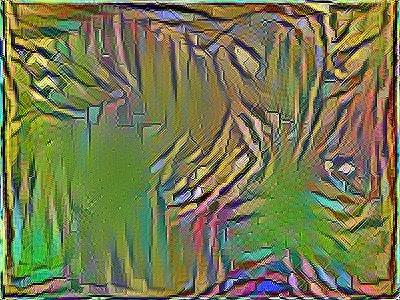

In [44]:
NST()